In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import warnings
warnings.simplefilter(action="ignore")

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes


In [4]:
df.shape

(7043, 21)

In [5]:
df.dtypes
#Total charges should be a numeric type

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [6]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors ='coerce')
#errorlari görmezden gel

In [7]:
df["TotalCharges"].dtype

dtype('float64')

In [8]:
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0 )

In [9]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1


In [10]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
check_df(df)

##################### Shape #####################
(7043, 21)
##################### Types #####################
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object
##################### Head #####################
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes  

In [11]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 2


In [12]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

for col in cat_cols:
    cat_summary(df, col)

        gender  Ratio
Male      3555 50.476
Female    3488 49.524
##########################################
     Partner  Ratio
No      3641 51.697
Yes     3402 48.303
##########################################
     Dependents  Ratio
No         4933 70.041
Yes        2110 29.959
##########################################
     PhoneService  Ratio
Yes          6361 90.317
No            682  9.683
##########################################
                  MultipleLines  Ratio
No                         3390 48.133
Yes                        2971 42.184
No phone service            682  9.683
##########################################
             InternetService  Ratio
Fiber optic             3096 43.959
DSL                     2421 34.375
No                      1526 21.667
##########################################
                     OnlineSecurity  Ratio
No                             3498 49.666
Yes                            2019 28.667
No internet service            1526 21.667


In [13]:
# KATEGORİK DEĞİŞKENLERİN TARGET GÖRE ANALİZİ
##################################


def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "Churn", col)

gender
        TARGET_MEAN  Count  Ratio
Female        0.269   3488 49.524
Male          0.262   3555 50.476


Partner
     TARGET_MEAN  Count  Ratio
No         0.330   3641 51.697
Yes        0.197   3402 48.303


Dependents
     TARGET_MEAN  Count  Ratio
No         0.313   4933 70.041
Yes        0.155   2110 29.959


PhoneService
     TARGET_MEAN  Count  Ratio
No         0.249    682  9.683
Yes        0.267   6361 90.317


MultipleLines
                  TARGET_MEAN  Count  Ratio
No                      0.250   3390 48.133
No phone service        0.249    682  9.683
Yes                     0.286   2971 42.184


InternetService
             TARGET_MEAN  Count  Ratio
DSL                0.190   2421 34.375
Fiber optic        0.419   3096 43.959
No                 0.074   1526 21.667


OnlineSecurity
                     TARGET_MEAN  Count  Ratio
No                         0.418   3498 49.666
No internet service        0.074   1526 21.667
Yes                        0.146   2019 28.667


O

count   7043.000
mean      32.371
std       24.559
min        0.000
5%         1.000
10%        2.000
20%        6.000
30%       12.000
40%       20.000
50%       29.000
60%       40.000
70%       50.000
80%       60.000
90%       69.000
95%       72.000
99%       72.000
max       72.000
Name: tenure, dtype: float64


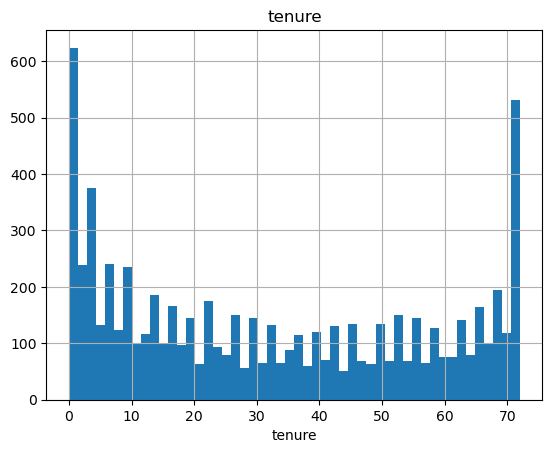

#####################################
count   7043.000
mean      64.762
std       30.090
min       18.250
5%        19.650
10%       20.050
20%       25.050
30%       45.850
40%       58.830
50%       70.350
60%       79.100
70%       85.500
80%       94.250
90%      102.600
95%      107.400
99%      114.729
max      118.750
Name: MonthlyCharges, dtype: float64


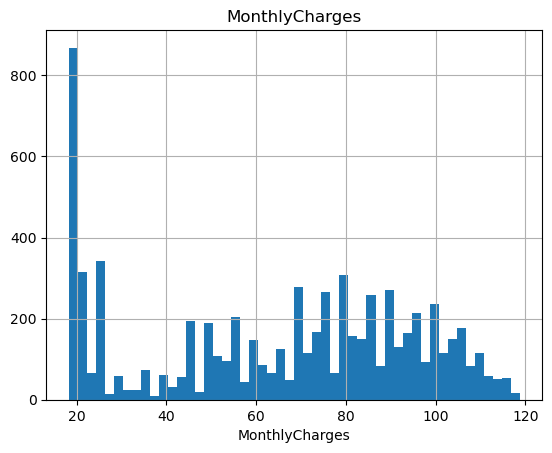

#####################################
count   7032.000
mean    2283.300
std     2266.771
min       18.800
5%        49.605
10%       84.600
20%      267.070
30%      551.995
40%      944.170
50%     1397.475
60%     2048.950
70%     3141.130
80%     4475.410
90%     5976.640
95%     6923.590
99%     8039.883
max     8684.800
Name: TotalCharges, dtype: float64


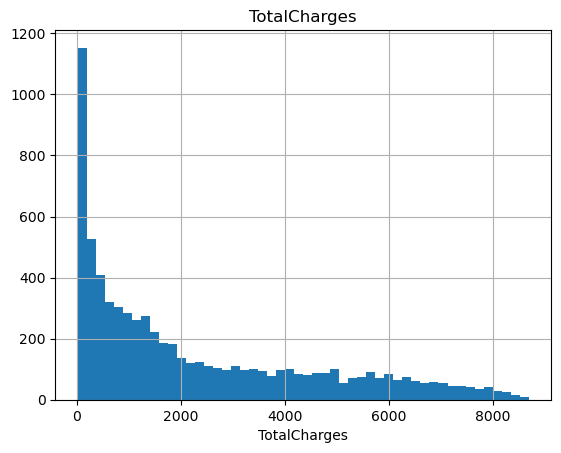

#####################################


In [14]:
######################################
# 3. Sayısal Değişken Analizi (Analysis of Numerical Variables)
######################################

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")


for col in num_cols:
    num_summary(df, col, True)

In [15]:
#Korelasyon Analizi
corr = df[num_cols].corr()
corr

,tenure,MonthlyCharges,TotalCharges
tenure,1.000,0.248,0.826
MonthlyCharges,0.248,1.000,0.651
TotalCharges,0.826,0.651,1.000


In [16]:
numeric_df = df.select_dtypes(include=[np.number])  # Sadece sayısal sütunları seç
correlation_with_churn = numeric_df.corrwith(df["Churn"]).sort_values(ascending=False)
print(correlation_with_churn)

#As churn (customer loss) increases, tenure (stay period) decreases. There is an inverse situation
# It can be inferred that new customers leave in a short time.

Churn             1.000
MonthlyCharges    0.193
SeniorCitizen     0.151
TotalCharges     -0.199
tenure           -0.352
dtype: float64


In [17]:
def missing_values_table(dataframe, na_name = False):
    na_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending = False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)],axis = 1,keys = ['n_miss','ratio'])
    print(missing_df,end = "\n")

    if na_name:
        return na_columns
missing_values_table(df)

              n_miss  ratio
TotalCharges      11  0.160


In [18]:
df.loc[df["TotalCharges"].isnull()]
# all have a tenure value of 0.
# since a month has not been filled yet, TotalCharges columns have a NaN value.

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.550,NaN,0
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.250,NaN,0
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.850,NaN,0
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.750,NaN,0
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.050,NaN,0
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.850,NaN,0
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.350,NaN,0
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.000,NaN,0
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.700,NaN,0
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.350,NaN,0


In [19]:
df.loc[df["TotalCharges"].isnull(), "TotalCharges"] = df["MonthlyCharges"]

In [20]:
df["tenure"] = df["tenure"] + 1

In [21]:
df[df["tenure"] == 1]
#missing values

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,1,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.550,52.550,0
753,3115-CZMZD,Male,0,No,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.250,20.250,0
936,5709-LVOEQ,Female,0,Yes,Yes,1,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.850,80.850,0
1082,4367-NUYAO,Male,0,Yes,Yes,1,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.750,25.750,0
1340,1371-DWPAZ,Female,0,Yes,Yes,1,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.050,56.050,0
3331,7644-OMVMY,Male,0,Yes,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.850,19.850,0
3826,3213-VVOLG,Male,0,Yes,Yes,1,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.350,25.350,0
4380,2520-SGTTA,Female,0,Yes,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.000,20.000,0
5218,2923-ARZLG,Male,0,Yes,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.700,19.700,0
6670,4075-WKNIU,Female,0,Yes,Yes,1,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.350,73.350,0


In [22]:
#Check Outliers

def outlier_threshold(dataframe, col_name, q1, q3):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    low_limit = quartile1 - 1.5 * interquantile_range
    up_limit = quartile3 + 1.5 * interquantile_range
    return low_limit,up_limit

def check_outlier(dataframe, col_name,q1,q3):
    low_limit,up_limit = outlier_threshold(dataframe,col_name,q1,q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [23]:
#check if there is a outlier in numerical values

for col in num_cols:
    print(col,check_outlier(df, col,0.05,0.95))

tenure False
MonthlyCharges False
TotalCharges False


In [24]:
###### Base Model
## How successful is our model before applying feature engineering?

dff = df.copy()
cat_cols = [col for col in cat_cols if col not in ["Churn"]]
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen']

In [53]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    #Edit the dummy columns as 0/1
    dataframe = dataframe.astype({col: int for col in dataframe.columns if any(cat in col for cat in categorical_cols)})
    return dataframe

#Assigning the encoding process to dff
dff = one_hot_encoder(dff,cat_cols,drop_first=True)

In [55]:
dff.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1
0,7590-VHVEG,2,29.850,29.850,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,5575-GNVDE,35,56.950,1889.500,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,3668-QPYBK,3,53.850,108.150,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,7795-CFOCW,46,42.300,1840.750,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
4,9237-HQITU,3,70.700,151.650,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [57]:
y = dff["Churn"]
X = dff.drop(["Churn","customerID"],axis=1)

models = [('LR', LogisticRegression(random_state=12345)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=12345)),
          ('RF', RandomForestClassifier(random_state=12345)),
          ('SVM', SVC(gamma='auto', random_state=12345)),
          ('XGB', XGBClassifier(random_state=12345)),
          ("LightGBM", LGBMClassifier(random_state=12345)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=12345))]

for name, model in models:
    cv_results = cross_validate(model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])
    print(f"########## {name} ##########")
    print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
    print(f"Auc: {round(cv_results['test_roc_auc'].mean(), 4)}")
    print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")
    print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
    print(f"F1: {round(cv_results['test_f1'].mean(), 4)}")


########## LR ##########
Accuracy: 0.8041
Auc: 0.8433
Recall: 0.5436
Precision: 0.659
F1: 0.5953


  File "C:\Users\90530\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


########## KNN ##########
Accuracy: 0.7632
Auc: 0.7459
Recall: 0.4462
Precision: 0.5695
F1: 0.4999
########## CART ##########
Accuracy: 0.728
Auc: 0.6586
Recall: 0.5077
Precision: 0.4886
F1: 0.4977
########## RF ##########
Accuracy: 0.792
Auc: 0.8252
Recall: 0.4842
Precision: 0.6448
F1: 0.5529
########## SVM ##########
Accuracy: 0.7684
Auc: 0.7135
Recall: 0.2884
Precision: 0.644
F1: 0.3979
########## XGB ##########
Accuracy: 0.7833
Auc: 0.8228
Recall: 0.5072
Precision: 0.6123
F1: 0.5542
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1682, number of negative: 4656
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 6338, number of used features: 30
[LightGB

Bağımlı değişken y ve bağımsız değişken x (Churn'u etkileyen değerler) atandı.Logistic Regression,K-Nearest Neighbors,CART,Random Forest,Support Vector Machine,X Gradient Boosting ,LightGBM,Catboost modelleri uygulandı.10 katlı cross validate yöntemi ile modellerin Accuracy,Auc,Recall,Precision,F1 score değerleri ölçüldü.

Şimdi bazı özellik eklemeleri yaparak tekrardan model başarımızı ölçelim

In [60]:

#Tenure column was effective so , A new feature can be derived from the tenure variable.

df.loc[(df["tenure"]>=0) & (df["tenure"]<=12),"NEW_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["tenure"]>12) & (df["tenure"]<=24),"NEW_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["tenure"]>24) & (df["tenure"]<=36),"NEW_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["tenure"]>36) & (df["tenure"]<=48),"NEW_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["tenure"]>48) & (df["tenure"]<=60),"NEW_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["tenure"]>60) & (df["tenure"]<=72),"NEW_TENURE_YEAR"] = "5-6 Year"


In [62]:

# Contracts with a duration of one year or two years are labeled as 'engaged'

df["NEW_Engaged"] = df["Contract"].apply(lambda x:1 if x in ["One year","Two year"] else 0)

In [64]:
# Young customers with a monthly contract.
df["NEW_Young_Not_Engaged"] = df.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis=1)


In [66]:
# The total number of services received by the person
df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)
# People who subscribe to any streaming service
df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

# Is the person making automatic payments?
df["NEW_FLAG_AutoPayment"] = df["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)

# Average monthly payment
df["NEW_AVG_Charges"] = df["TotalCharges"] / (df["tenure"] + 1)

# Increase of the current price compared to the average price.
df["NEW_Increase"] = df["NEW_AVG_Charges"] / df["MonthlyCharges"]

# Fee per service
df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)


df.head()
df.shape

(7043, 30)

In [68]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_TENURE_YEAR,NEW_Engaged,NEW_Young_Not_Engaged,NEW_TotalServices,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee
0,7590-VHVEG,Female,0,Yes,No,2,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0,0-1 Year,0,1,1,0,0,9.950,0.333,14.925
1,5575-GNVDE,Male,0,No,No,35,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0,2-3 Year,1,0,3,0,0,52.486,0.922,14.238
2,3668-QPYBK,Male,0,No,No,3,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1,0-1 Year,0,1,3,0,0,27.038,0.502,13.463
3,7795-CFOCW,Male,0,No,No,46,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0,3-4 Year,1,0,3,0,1,39.165,0.926,10.575
4,9237-HQITU,Female,0,No,No,3,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1,0-1 Year,0,1,1,0,0,37.913,0.536,35.350


In [70]:
##################################
# ENCODING
##################################

# The process of separating variables by their types.
cat_cols, num_cols, cat_but_car = grab_col_names(df)

# LABEL ENCODING
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

Observations: 7043
Variables: 30
cat_cols: 23
num_cols: 6
cat_but_car: 1
num_but_cat: 7


['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

In [72]:
for col in binary_cols:
    df = label_encoder(df, col)

In [74]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_TENURE_YEAR,NEW_Engaged,NEW_Young_Not_Engaged,NEW_TotalServices,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee
0,7590-VHVEG,0,0,1,0,2,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.850,29.850,0,0-1 Year,0,1,1,0,0,9.950,0.333,14.925
1,5575-GNVDE,1,0,0,0,35,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.950,1889.500,0,2-3 Year,1,0,3,0,0,52.486,0.922,14.238
2,3668-QPYBK,1,0,0,0,3,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.850,108.150,1,0-1 Year,0,1,3,0,0,27.038,0.502,13.463
3,7795-CFOCW,1,0,0,0,46,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.300,1840.750,0,3-4 Year,1,0,3,0,1,39.165,0.926,10.575
4,9237-HQITU,0,0,0,0,3,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.700,151.650,1,0-1 Year,0,1,1,0,0,37.913,0.536,35.350


In [76]:
# One-Hot Encoding İşlemi
# Updating cat_cols list
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn", "NEW_TotalServices"]]
cat_cols

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

df.head()


,customerID,gender,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_TotalServices,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NEW_TENURE_YEAR_1-2 Year,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year,SeniorCitizen_1,NEW_Engaged_1,NEW_Young_Not_Engaged_1,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AutoPayment_1
0,7590-VHVEG,0,1,0,2,0,1,29.850,29.850,0,1,9.950,0.333,14.925,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,5575-GNVDE,1,0,0,35,1,0,56.950,1889.500,0,3,52.486,0.922,14.238,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0
2,3668-QPYBK,1,0,0,3,1,1,53.850,108.150,1,3,27.038,0.502,13.463,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,7795-CFOCW,1,0,0,46,0,0,42.300,1840.750,0,3,39.165,0.926,10.575,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1
4,9237-HQITU,0,0,0,3,1,1,70.700,151.650,1,1,37.913,0.536,35.350,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [78]:
##################################
# MODELLEME
##################################


y = df["Churn"]
X = df.drop(["Churn","customerID"], axis=1)


models = [('LR', LogisticRegression(random_state=12345)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=12345)),
          ('RF', RandomForestClassifier(random_state=12345)),
          ('SVM', SVC(gamma='auto', random_state=12345)),
          ('XGB', XGBClassifier(random_state=12345)),
          ("LightGBM", LGBMClassifier(random_state=12345)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=12345))]

for name, model in models:
    cv_results = cross_validate(model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])
    print(f"########## {name} ##########")
    print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
    print(f"Auc: {round(cv_results['test_roc_auc'].mean(), 4)}")
    print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")
    print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
    print(f"F1: {round(cv_results['test_f1'].mean(), 4)}")



########## LR ##########
Accuracy: 0.8007
Auc: 0.8417
Recall: 0.5067
Precision: 0.6635
F1: 0.574
########## KNN ##########
Accuracy: 0.7711
Auc: 0.7546
Recall: 0.4677
Precision: 0.5875
F1: 0.5198
########## CART ##########
Accuracy: 0.7284
Auc: 0.6575
Recall: 0.5035
Precision: 0.4881
F1: 0.4955
########## RF ##########
Accuracy: 0.7934
Auc: 0.8294
Recall: 0.5046
Precision: 0.641
F1: 0.5645
########## SVM ##########
Accuracy: 0.768
Auc: 0.7258
Recall: 0.2574
Precision: 0.6654
F1: 0.3701
########## XGB ##########
Accuracy: 0.7901
Auc: 0.8251
Recall: 0.5271
Precision: 0.6238
F1: 0.5712
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1682, number of negative: 4656
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1429
[

In [82]:
################################################
# Random Forests
################################################

#Optimization of Random Forest Model

rf_model = RandomForestClassifier(random_state=17)

rf_params = {"max_depth": [5, 8, None],
             "max_features": [3, 5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 15, 20],
             "n_estimators": [100, 200, 500]}

rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)


Fitting 5 folds for each of 180 candidates, totalling 900 fits


* **rf_params**: A hyperparameter grid is defined to optimize the model's hyperparameters:
  
* *max_depth:* The maximum depth of each decision tree.
* *max_features:* The maximum number of features to consider at each split.
* *min_samples_split:* The minimum number of samples required to split an internal node.
* *n_estimators:* The total number of trees in the forest.

**GridSearchCV** s used for hyperparameter combinations. It tests all combinations and finds the one that provides the best performance.


In [84]:
rf_best_grid.best_params_

{'max_depth': None,
 'max_features': 7,
 'min_samples_split': 20,
 'n_estimators': 500}

In [86]:
rf_best_grid.best_score_

0.8000865983289245

In [88]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)

In [89]:
cv_results = cross_validate(rf_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()

0.8006503868471955

In [90]:
cv_results['test_f1'].mean()

0.5744313898787928

In [91]:
cv_results['test_roc_auc'].mean()

0.8434966982749401

In [96]:
################################################
# XGBoost
################################################

xgboost_model = XGBClassifier(random_state=17)

xgboost_params = {"learning_rate": [0.1, 0.01, 0.001],
                  "max_depth": [5, 8, 12, 15, 20],
                  "n_estimators": [100, 500, 1000],
                  "colsample_bytree": [0.5, 0.7, 1]}

xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)


Fitting 5 folds for each of 135 candidates, totalling 675 fits


In [97]:
xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(xgboost_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()

0.803630923597679

In [98]:
cv_results['test_f1'].mean()

0.5853786939169673

In [102]:
cv_results['test_roc_auc'].mean()

0.8466994919566682

In [104]:
################################################
# LightGBM
################################################

lgbm_model = LGBMClassifier(random_state=17)

lgbm_params = {"learning_rate": [0.01, 0.1, 0.001],
               "n_estimators": [100, 300, 500, 1000],
               "colsample_bytree": [0.5, 0.7, 1]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(lgbm_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1869, number of negative: 5174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1429
[LightGBM] [Info] Number of data points in the train set: 7043, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265370 -> initscore=-1.018243
[LightGBM] [Info] Start training from score -1.018243
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1869, number of negative: 5174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

In [105]:
cv_results['test_accuracy'].mean()

0.8020696324951645

In [106]:

cv_results['test_f1'].mean()

0.5763016063493737

In [107]:

cv_results['test_roc_auc'].mean()

0.8470333146963392

In [112]:
################################################
# CatBoost
################################################

catboost_model = CatBoostClassifier(random_state=17, verbose=False)

catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}

catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(catboost_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [113]:
cv_results['test_accuracy'].mean()

0.8012185686653771

In [116]:
cv_results['test_f1'].mean()

0.5652253570815244

In [118]:
cv_results['test_roc_auc'].mean()

0.8476985486121723

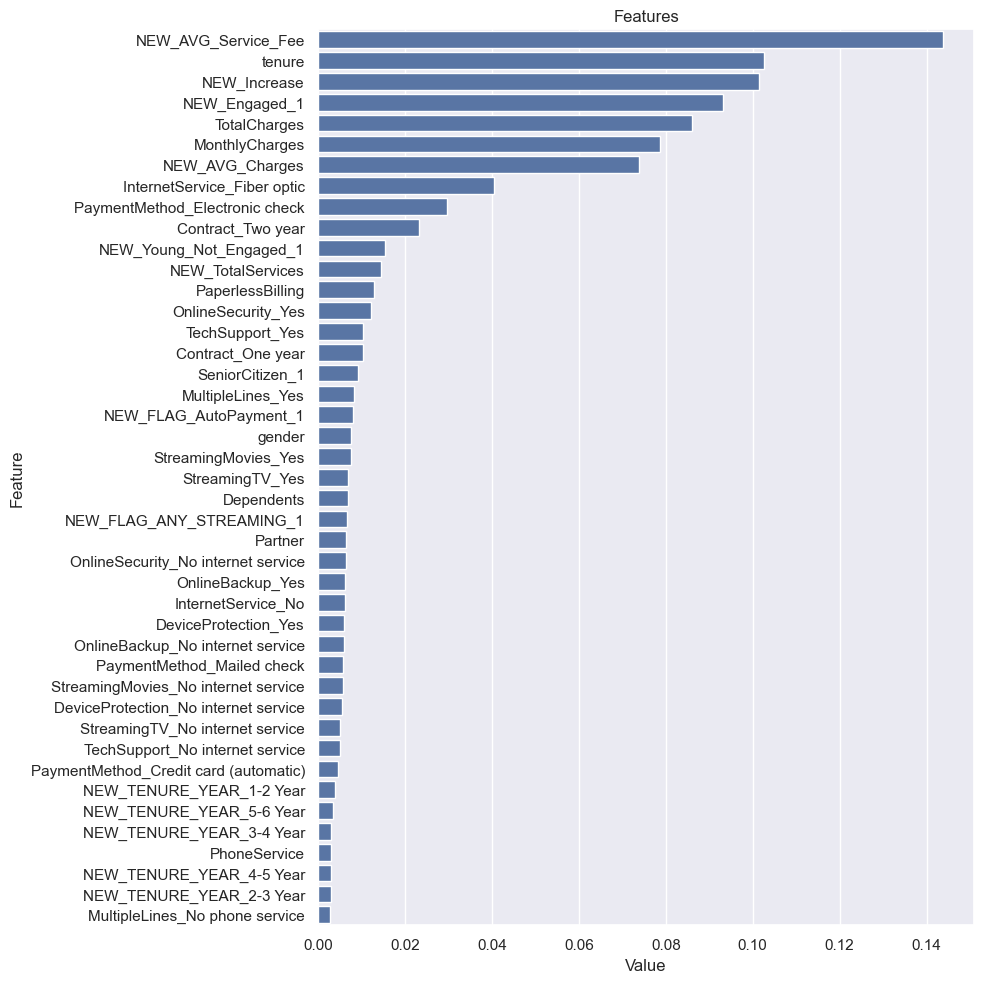

In [120]:
################################################
# Feature Importance
################################################

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_final, X)

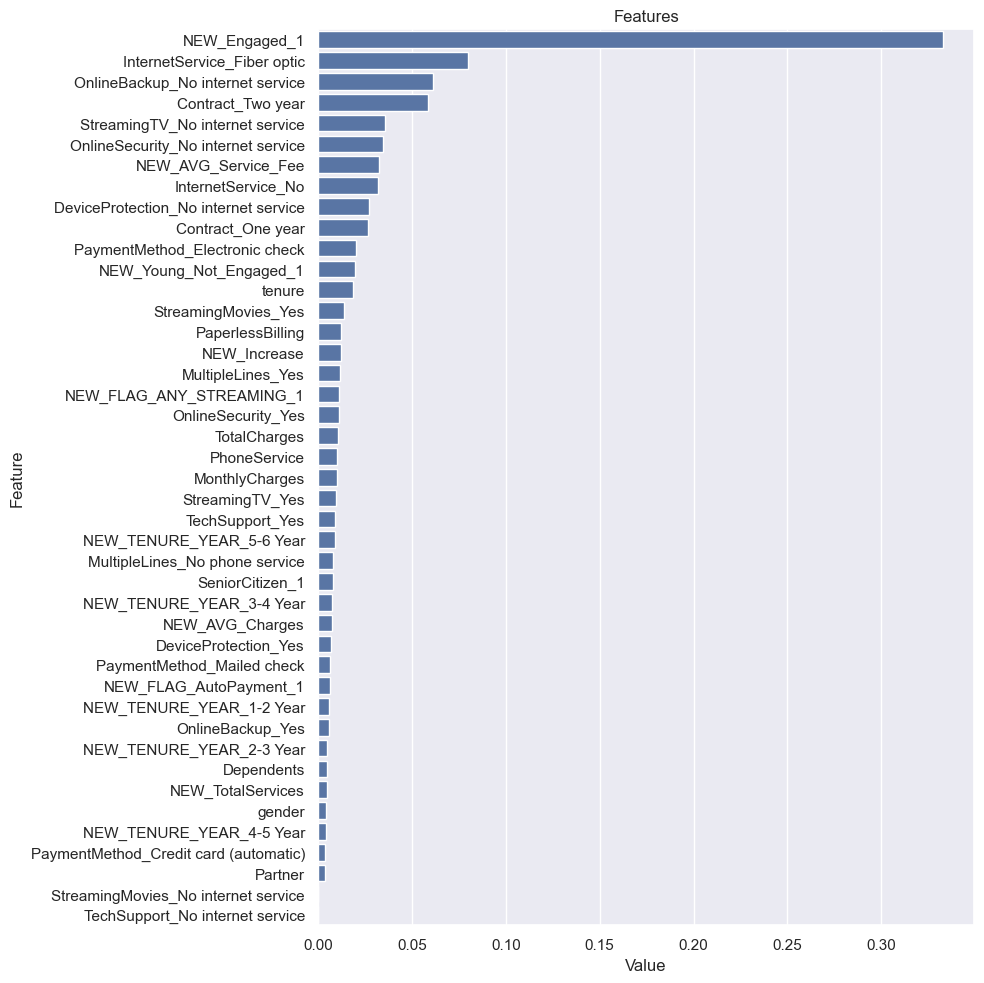

In [122]:
plot_importance(xgboost_final, X)

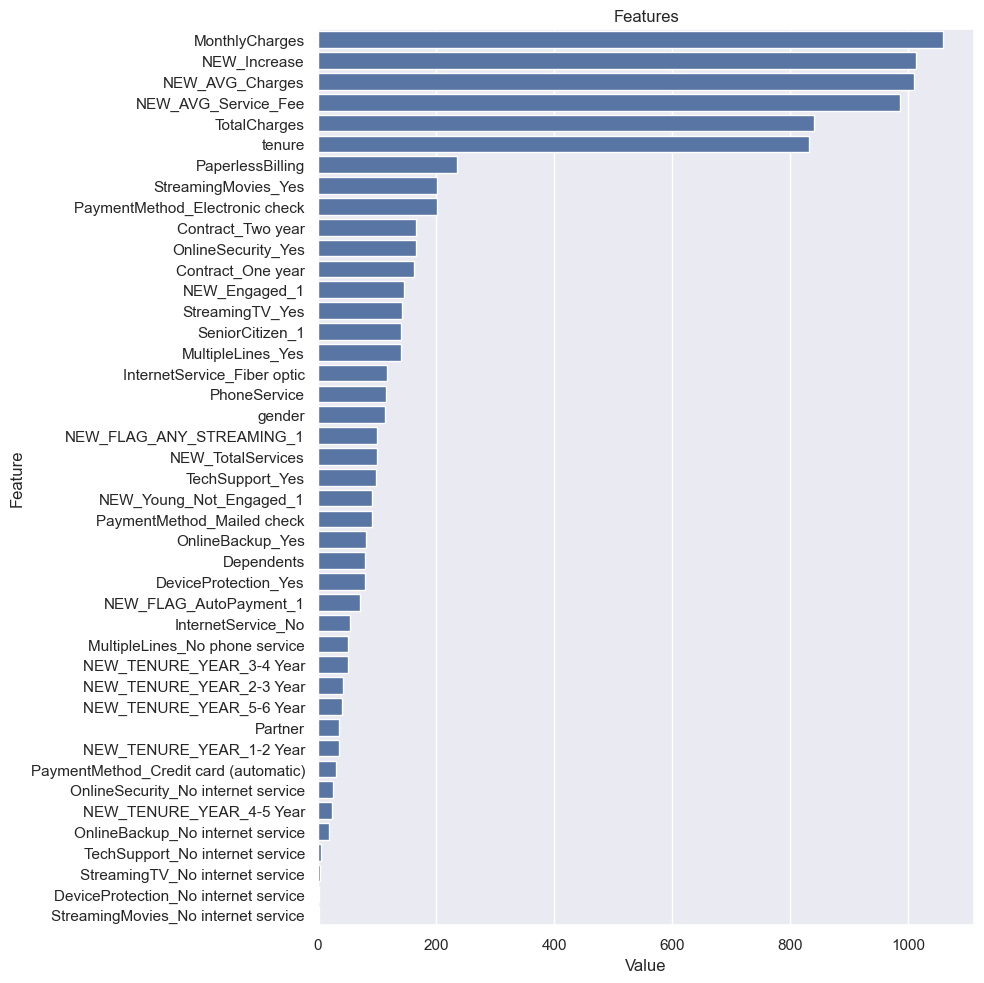

In [124]:
plot_importance(lgbm_final, X)

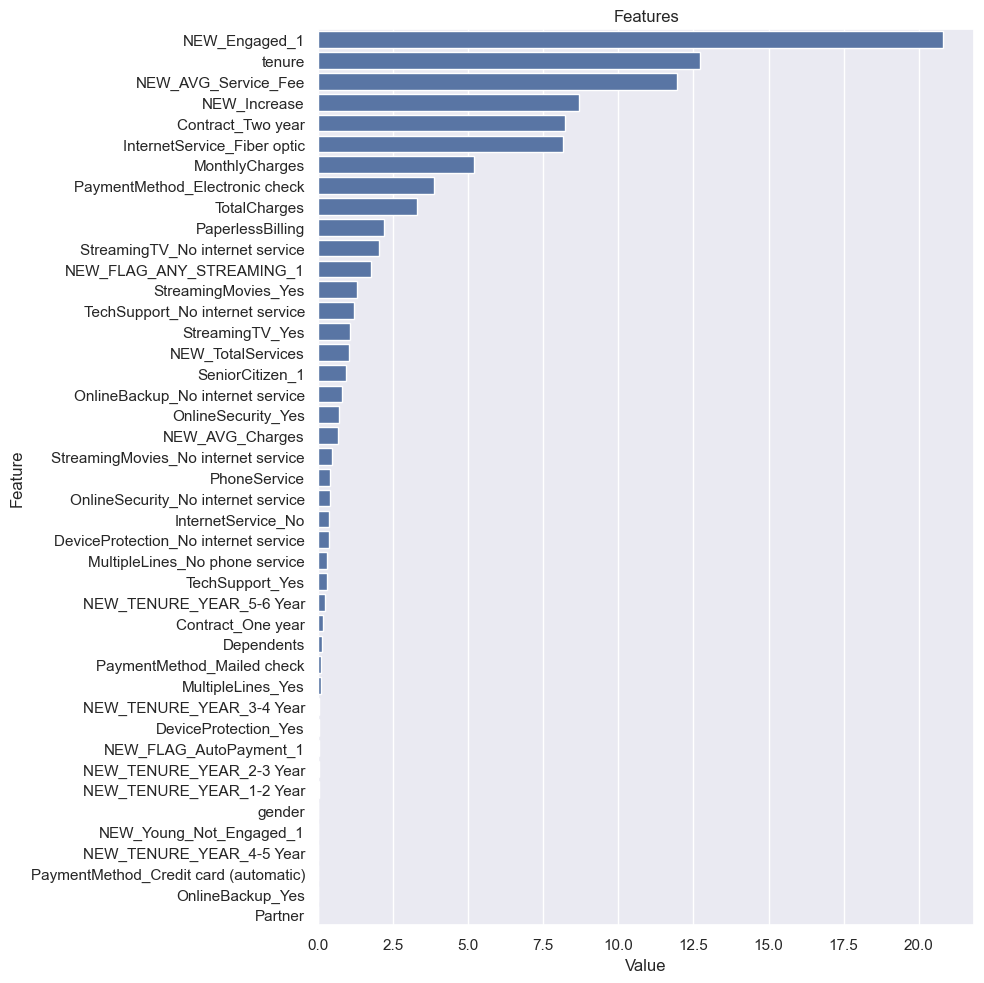

In [126]:
plot_importance(catboost_final, X)

In [128]:
# Lets look for NEW_AVG_Service_Fee 

# Fee per Service
# df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)
df.head()

,customerID,gender,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_TotalServices,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NEW_TENURE_YEAR_1-2 Year,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year,SeniorCitizen_1,NEW_Engaged_1,NEW_Young_Not_Engaged_1,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AutoPayment_1
0,7590-VHVEG,0,1,0,2,0,1,29.850,29.850,0,1,9.950,0.333,14.925,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,5575-GNVDE,1,0,0,35,1,0,56.950,1889.500,0,3,52.486,0.922,14.238,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0
2,3668-QPYBK,1,0,0,3,1,1,53.850,108.150,1,3,27.038,0.502,13.463,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,7795-CFOCW,1,0,0,46,0,0,42.300,1840.750,0,3,39.165,0.926,10.575,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1
4,9237-HQITU,0,0,0,3,1,1,70.700,151.650,1,1,37.913,0.536,35.350,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [130]:
# Create a copy of the DataFrame and permanently remove the NEW_AVG_Service_Fee column from df2
df2 = df.copy()
df2.drop("NEW_AVG_Service_Fee",axis=1,inplace=True)
df2.columns

Index(['customerID', 'gender', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'NEW_TotalServices', 'NEW_AVG_Charges', 'NEW_Increase',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'NEW_TENURE_YEAR_1-2 Year', 'NEW_TENURE_YEAR_2-3 Year',
       'NEW_TENURE_YEAR_3-4 Year', 'NEW_

In [132]:
#Build a model for df2 and check the scores of LightGBM and CatBoost.
y = df2["Churn"]
X = df2.drop(["Churn","customerID"],axis=1)

models = [
          ('XGB', XGBClassifier(random_state=12345)),
          ("LightGBM", LGBMClassifier(random_state=12345)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=12345))]

for name, model in models:
    cv_results = cross_validate(model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])
    print(f"########## {name} ##########")
    print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
    print(f"Auc: {round(cv_results['test_roc_auc'].mean(), 4)}")
    print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")
    print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
    print(f"F1: {round(cv_results['test_f1'].mean(), 4)}")


###################
# For the base model: After removing NEW_AVG_Service_Fee, XGB's Accuracy, Precision, and AUC increased. LightGBM's Accuracy increased, except for the other metrics. CatBoost increased.

########## XGB ##########
Accuracy: 0.7882
Auc: 0.8263
Recall: 0.519
Precision: 0.6208
F1: 0.5652
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1682, number of negative: 4656
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 6338, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265383 -> initscore=-1.018173
[LightGBM] [Info] Start training from score -1.018173
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1682, number of negative: 4656
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `f

In [141]:
#XGboost with Best params
cv_results = cross_validate(xgboost_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()
# The XGBoost best parameters' score values decreased after removing NEW_AVG_Service_Fee

0.8029223081882655

In [134]:
cv_results['test_f1'].mean()

0.5833460868210564

In [135]:
cv_results['test_roc_auc'].mean()

0.8481936480874854